# sLLM을 활용한 채팅형 게임 만들기

[목차]
1. 게임 설명
2. 모델 로드
3. 게임 구현

게임 개요

________

# 1. 모델로드
모델 : Kanana-nano-2.1B (카카오, 2025-02 공개)

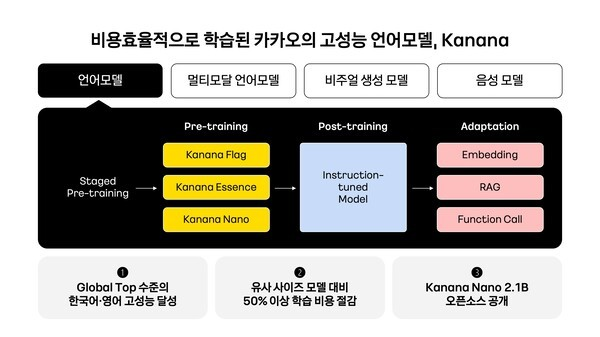

출처 : https://share.google/images/SXLYF2UpC5UJRV1ir

In [ ]:
# 필요라이브러리
from dotenv import load_dotenv
from openai import OpenAI
import os
import re
import json
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
from openai import OpenAI
from google.colab import userdata

In [ ]:
api_key = userdata.get('OPENAI_API_KEY')
client = OpenAI(api_key=api_key)

In [ ]:
type(client)

openai.OpenAI

In [ ]:
# 모델 로드 from huggingface

model_name = "kakaocorp/kanana-nano-2.1b-instruct"

tokenizer = AutoTokenizer.from_pretrained(model_name)

if tokenizer.pad_token_id is None:
    tokenizer.pad_token_id = tokenizer.eos_token_id

# Load the Hugging Face token from Colab's user data secrets
from google.colab import userdata
HF_TOKEN = userdata.get('HF_TOKEN')

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype= "auto",
    token = HF_TOKEN,
    device_map="auto"
)

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/444 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/718 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/4.17G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/126 [00:00<?, ?B/s]

In [ ]:
# 테스트 구문
#prompt = "'나는 솔로'프로그램 등장인물 들의 특징을 설명해줘"
#inputs = tokenizer(prompt, return_tensors="pt")
#outputs = model.generate(**inputs, max_new_tokens=200)

#print(tokenizer.decode(outputs[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


'나는 솔로'프로그램 등장인물 들의 특징을 설명해줘.
물론이죠! '나는 솔로' 프로그램에 등장하는 주요 인물들의 특징을 간단히 설명해드릴게요.

### 1. 주인공, 솔로녀 (박솔로)
- **특징**: 
  - 30대 초반의 직장인으로, 독립적인 성격을 가지고 있으며 솔직하고 직설적인 성향을 보입니다.
  - 연애에 있어서는 신중하고 깊이 있는 관계를 선호합니다.
  - 외모보다는 내면의 가치와 감정을 중시합니다.

### 2. 솔로남 (이진우)
- **특징**:
  - 30대 초반의 대기업 직원으로, 외향적이고 사교적인 성격을 가지고 있습니다.
  - 다소 즉흥적이고 감정 표현이 풍부한 편입니다.
  - 연애에 있어서는 열정적이고 적


________

# 2. 게임 구현

In [ ]:
import random
import re
import os
from PIL import Image
import base64
import time, sys

In [ ]:
"""
from IPython.display import display
from PIL import Image

# Colab에서 API 키를 문자열로 받으셨다 했으니 그대로 사용
#API_KEY = userdata.get('OPENAI_API_KEY')  # 또는 os.environ["OPENAI_API_KEY"]

avatar_path = make_image_with_openai_http(api_key, "/content/mountainstar.JPG", "avatar.png",size="1024x1024")
display(Image.open(avatar_path))
"""

'\nfrom IPython.display import display\nfrom PIL import Image\n\n# Colab에서 API 키를 문자열로 받으셨다 했으니 그대로 사용\n#API_KEY = userdata.get(\'OPENAI_API_KEY\')  # 또는 os.environ["OPENAI_API_KEY"]\n\navatar_path = make_image_with_openai_http(api_key, "/content/mountainstar.JPG", "avatar.png",size="1024x1024")\ndisplay(Image.open(avatar_path))\n'

#### 캐릭터 페르소나 설정

In [ ]:
# 캐릭터 페르소나 설정

characters = [
    {
        "id":"M1",
        "name":"영호",
        "gender":"M",
        "age":1980,
        "persona":"감성·자기서사·예술적, 성악가 출신. 낭만형. 감정적.",
        "style":"예술가처럼 은유 섞은 말투. 감정을 크게 표현."
    },
    {
        "id":"M2",
        "name":"영식",
        "gender":"M",
        "age":1989,
        "persona":"경쟁·도발·자신감, 외국계 세일즈맨.",
        "style":"느끼하고 직설적인 말투. 유머를 비꼬듯 섞음."
    },
    {
        "id":"M3",
        "name":"상철",
        "gender":"M",
        "age":1982,
        "persona":"원칙·고집·건조, 방산회사 직원. 가부장적.",
        "style":"무뚝뚝하고 단답형. 고집스러운 말투."
    },
    {
        "id":"F1",
        "name":"정숙",
        "gender":"F",
        "age":1978,
        "persona":"직설·기싸움, 요식업 사업가.",
        "style":"부산 사투리를 쓰며, 말꼬투리 잡고 논쟁 유발. 털털한스타일."
    },
    {
        "id":"F2",
        "name":"영숙",
        "gender":"F",
        "age":1990,
        "persona":"리액션 과장·감정기복, 무용강사.",
        "style":"부산 사투리를 섞어 과장된 리액션을 함. "
    },
    {
        "id":"F3",
        "name":"옥순",
        "gender":"F",
        "age":1995,
        "persona":"돌직구·애교/의존, 공주병 경향.",
        "style":"애교 많고 남자에게 의존적인 말투. 도도함."
    },
]

#### 기본 setting 함수
- 1. 사용자 정보 받기 함수
- 2. 성별에 따른 공략 대상 성별 구분 함수
- 3. 조효용 딕셔너리
- 4. 초기호감도 설정함수
- 5. 호감도 출력함수
- 6. 간단한 호감도 측정 [말걸면 호감도 상승]

In [ ]:
# 1. 사용자 정보 받기 함수
GAME_CONFIG = {
    "initial_favor_base": 25,
    "initial_favor_rand": 10,
    "initial_trust_base": 35,
    "initial_spark_base": 30,
    "initial_jealousy_base": 15,
    "talk_base_bonus": 2,
    "event_help_bonus": 8,
    "event_skip_penalty": -8,
    "favor_min": 0,
    "favor_max": 100,
    "stat_min": 0,
    "stat_max": 100,
    "day_chat_rounds": 3,
    "passive_jealousy_per_date": 3,
}


def clamp_favor(score: int) -> int:
    return max(GAME_CONFIG["favor_min"], min(GAME_CONFIG["favor_max"], int(score)))


def clamp_stat(score: int) -> int:
    return max(GAME_CONFIG["stat_min"], min(GAME_CONFIG["stat_max"], int(score)))


def apply_favor_delta(favor, cid, delta):
    before = favor.get(cid, 0)
    favor[cid] = clamp_favor(before + int(delta))
    return favor[cid] - before


def apply_state_delta(states, cid, key, delta):
    before = states[cid].get(key, 0)
    states[cid][key] = clamp_stat(before + int(delta))
    return states[cid][key] - before


def merge_effect(dst, src):
    for k in ("favor", "trust", "spark", "jealousy"):
        dst[k] += int(src.get(k, 0))
    return dst


def user():
    name = input("나의 이름: ").strip()
    age = input("나이: ").strip()
    job = input("직업: ").strip()

    gender_raw = input("성별을 입력하세요 (남/여): ").strip()
    if gender_raw == "남":
        gender = "M"
    elif gender_raw == "여":
        gender = "F"
    else:
        print("입력값을 이해하지 못해 기본값 'M'으로 설정합니다.")
        gender = "M"

    return {"name": name or "플레이어", "age": age, "job": job, "gender": gender}


# 2. 성별에 따른 공략 대상 성별 구분 함수
def target_gender(characters, player_gender):
    opp = "F" if player_gender == "M" else "M"
    return [c for c in characters if c["gender"] == opp]


# 3. 조회용 딕셔너리 변경
char_dict = {c["id"]: c for c in characters}


# 4. 초기호감도/감정 스탯 설정 함수
def first_love(pool, seed=None):
    """초기 호감도: base + 랜덤(0~rand)"""
    rng = random.Random(seed) if seed is not None else random
    base = GAME_CONFIG["initial_favor_base"]
    spread = GAME_CONFIG["initial_favor_rand"]
    return {c["id"]: clamp_favor(base + rng.randint(0, spread)) for c in pool}


def init_states(pool, seed=None):
    rng = random.Random((seed + 999) if seed is not None else None)
    states = {}
    for c in pool:
        states[c["id"]] = {
            "trust": clamp_stat(GAME_CONFIG["initial_trust_base"] + rng.randint(-5, 5)),
            "spark": clamp_stat(GAME_CONFIG["initial_spark_base"] + rng.randint(-5, 5)),
            "jealousy": clamp_stat(GAME_CONFIG["initial_jealousy_base"] + rng.randint(-5, 5)),
        }
    return states


# 5. 호감도 출력 함수
def love_bar(score, steps=10) -> str:
    score = clamp_favor(score)
    filled = round(score / (100 / steps))
    empty = steps - filled
    return "❤️" * filled + "🤍" * empty


# 6. 상태 출력 함수
def print_love(favor, pool, states=None):
    print("호감도")
    print("-" * 48)
    for c in pool:
        cid = c["id"]
        name = c["name"]
        sc = favor.get(cid, 0)
        bar = love_bar(sc, steps=10)
        if states is None:
            print(f"{name:<4} | {bar} {sc:3d}")
        else:
            st = states[cid]
            print(f"{name:<4} | {bar} {sc:3d} | 신뢰 {st['trust']:>2} 설렘 {st['spark']:>2} 질투 {st['jealousy']:>2}")
    print("-" * 48)


# 7. 공략대상별 공략 포인트
KEYWORDS = [
    (["뮤즈", "로맨틱", "노래", "예술", "스윗", "잘생", "오빠"], {"M1": {"favor": 3, "spark": 3}}),
    (["인정", "팩트", "스테이블", "성과"], {"M2": {"favor": 3, "trust": 2}}),
    (["계획", "원칙", "기준", "결론"], {"M3": {"favor": 2, "trust": 3}}),
    (["직설", "팩폭", "솔직"], {"F1": {"favor": 3, "trust": 2}}),
    (["응원", "고마워", "힘내"], {"F2": {"favor": 2, "trust": 3, "spark": 1}}),
    (["오빠", "챙겨줘", "귀여워", "애교"], {"F3": {"favor": 3, "spark": 3}}),
]


# 8. 공략하기_(1)말걸기_<tipping_chat>
def tipping_chat(favor, states, text, target_id):
    """대화 룰 기반 점수 적용: 기본 보너스 + 키워드 보너스"""
    effect = {"favor": 0, "trust": 0, "spark": 0, "jealousy": 0}
    matched_keywords = []

    effect["favor"] += apply_favor_delta(favor, target_id, GAME_CONFIG["talk_base_bonus"])
    effect["spark"] += apply_state_delta(states, target_id, "spark", 1)

    t = (text or "").strip()
    for words, char_effects in KEYWORDS:
        hit = [w for w in words if w in t]
        if not hit:
            continue
        matched_keywords.extend(hit)

        for cid, delta_map in char_effects.items():
            if cid not in favor:
                continue
            for key, delta in delta_map.items():
                if key == "favor":
                    effect["favor"] += apply_favor_delta(favor, cid, delta)
                else:
                    effect[key] += apply_state_delta(states, cid, key, delta)

    return effect, sorted(set(matched_keywords))


def apply_llm_effect(favor, states, cid, llm_delta):
    """LLM 점수를 호감도와 감정 스탯으로 분배"""
    effect = {"favor": 0, "trust": 0, "spark": 0, "jealousy": 0}

    effect["favor"] += apply_favor_delta(favor, cid, llm_delta)
    if llm_delta >= 0:
        effect["trust"] += apply_state_delta(states, cid, "trust", max(1, llm_delta // 3))
        effect["spark"] += apply_state_delta(states, cid, "spark", max(1, llm_delta // 2))
        effect["jealousy"] += apply_state_delta(states, cid, "jealousy", -max(1, llm_delta // 4))
    else:
        amount = abs(llm_delta)
        effect["trust"] += apply_state_delta(states, cid, "trust", -max(1, amount // 2))
        effect["spark"] += apply_state_delta(states, cid, "spark", -max(1, amount // 3))
        effect["jealousy"] += apply_state_delta(states, cid, "jealousy", max(1, amount // 2))

    return effect


def apply_passive_jealousy(states, pool, target_id, amount):
    for c in pool:
        cid = c["id"]
        if cid == target_id:
            continue
        apply_state_delta(states, cid, "jealousy", amount)


####  LLM기반 채팅 함수

In [ ]:
# 새프롬프트
def llm_reply(
    char,
    user_text,
    do_sample=False,
    max_new_tokens=60,
    memory_summary="",
    favor_score=None,
    relation_state=None,
):
    system = (
        "너는 한국 예능 '나는 솔로'의 해당 출연자 그 자체다. "
        "오직 캐릭터 1인칭으로만 말한다. "
        "해설/메타/역할표시/괄호 금지. 플레이어 대사 생성 금지. "
        "짧고 자연스럽게. "
        "모든 답변은 존댓말로. 반말 금지."
    )

    memory_hint = f"최근 기억: {memory_summary}\n" if memory_summary else ""
    favor_hint = f"현재 호감도: {favor_score}\n" if favor_score is not None else ""
    emotion_hint = ""
    if relation_state:
        emotion_hint = (
            f"현재 감정상태(내 기준): 신뢰 {relation_state.get('trust', 0)}, "
            f"설렘 {relation_state.get('spark', 0)}, 질투 {relation_state.get('jealousy', 0)}\n"
        )

    user = (
        f"캐릭터: {char['name']} / 성향:{char.get('persona','')} / 말투:{char.get('style','')}\n"
        f"{favor_hint}{emotion_hint}{memory_hint}"
        f"플레이어: {user_text}"
    )
    prompt = f"{system}\n\n{user}\n\n답변:"

    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=1024)
    device = next(model.parameters()).device
    inputs = {k: v.to(device) for k, v in inputs.items()}

    waiting = "(⏳ ...응답 고민 중... 흠냐링 ... ⏳)"
    for c in waiting:
        sys.stdout.write(c)
        sys.stdout.flush()
        time.sleep(0.02)
    print()

    out = model.generate(
        **inputs,
        max_new_tokens=max_new_tokens,
        do_sample=do_sample,
        temperature=0.6 if do_sample else None,
        top_p=0.9 if do_sample else None,
        no_repeat_ngram_size=3,
        repetition_penalty=1.08,
        use_cache=True,
        pad_token_id=getattr(tokenizer, "pad_token_id", tokenizer.eos_token_id),
    )
    text = tokenizer.decode(out[0], skip_special_tokens=True)

    text = text.split("답변:", 1)[-1]
    text = re.sub(r"\[[^\]]*\]", "", text)
    text = re.sub(r"\([^)]*\)", "", text)

    cleaned_lines = []
    for ln in text.splitlines():
        t = ln.strip()
        if not t:
            continue
        if any(x in t for x in ("시스템", "사용자", "플레이어", "캐릭터", "가이드", "지침", "최근 기억", "현재 감정상태")):
            continue
        cleaned_lines.append(t)

    text = " ".join(cleaned_lines)
    text = re.sub(r"\s+", " ", text).strip()

    sents = re.split(r"(?<=[\.!?！？…])\s+", text)
    sents = [s.strip() for s in sents if s.strip()]
    if len(sents) > 2:
        sents = sents[:2]

    return " ".join(sents) if sents else "네, 말씀 고맙습니다."


<>:61: SyntaxWarning: invalid escape sequence '\['
<>:61: SyntaxWarning: invalid escape sequence '\['
/tmp/ipython-input-2133130839.py:61: SyntaxWarning: invalid escape sequence '\['
  raw = re.sub(r"\[[^\]]*\]", "", raw)


#### 모든 대화 축적 함수

In [ ]:
# 여러 대화 턴 keep
def memory_context(log, limit=4):
    if not log:
        return ""
    return " / ".join(log[-limit:])


def multi_chat(char, rounds=3, player_name="산별", favor=None, states=None, memories=None):
    transcript = []
    rule_effect_total = {"favor": 0, "trust": 0, "spark": 0, "jealousy": 0}
    cid = char["id"]

    for _ in range(rounds):
        user_text = input(f"[{player_name}] : ").strip()
        transcript.append({"role": "user", "text": user_text})

        matched = []
        if favor is not None and states is not None:
            eff, matched = tipping_chat(favor, states, user_text, target_id=cid)
            merge_effect(rule_effect_total, eff)

        summary = memory_context(memories.get(cid, []), limit=4) if memories is not None else ""
        reply = llm_reply(
            char,
            user_text,
            do_sample=True,
            memory_summary=summary,
            favor_score=favor.get(cid) if favor is not None else None,
            relation_state=states.get(cid) if states is not None else None,
        )
        print(f"[{char['name']}] {reply}")
        transcript.append({"role": "char", "text": reply})

        if memories is not None:
            tag = f"키워드:{','.join(matched)}" if matched else "키워드:없음"
            memories[cid].append(f"U:{user_text} | C:{reply} | {tag}")
            memories[cid] = memories[cid][-12:]

    return transcript, rule_effect_total


#### llm 점수 계산함수
- 을 위한, 점수 추출 함수

In [ ]:
#### => 지피디니 도움 받음 /
def get_score(s: str):
    """정규식 없이 맨 앞 부호(+/-) 1개와 뒤이은 숫자만 읽어 정수로. 실패 시 None."""
    s = s.strip()
    if not s:
        return None
    out = ""
    for i, ch in enumerate(s):
        if i == 0 and ch in "+-":
            out += ch
        elif ch.isdigit():
            out += ch
        else:
            break
    if out in ("+", "-", ""):
        return None
    try:
        return int(out)
    except Exception:
        return None


def score_llm(transcript: list, char, debug: bool = False):
    lines = []
    for turn in transcript:
        who = "플레이어" if turn["role"] == "user" else char["name"]
        lines.append(f"{who}: {turn['text']}")
    all_chat = "\n".join(lines)

    system = (
        "너는 연애 예능의 심사위원이다. 아래 대화를 보고 "
        "상대 캐릭터가 사용자에게 줄 호감도 변화 점수(정수)를 판단하라. "
        "반드시 -20부터 20 사이의 정수 한 개만 출력하라. "
        "숫자 외에는 아무 것도 출력하지 마라."
    )
    fewshot = "예시: 15\n예시: -10\n예시: 0\n"
    user = (
        f"캐릭터: {char['name']} / 성향:{char.get('persona','')} / 말투:{char.get('style','')}\n"
        f"대화:\n{all_chat}\n\n"
        f"{fewshot}"
        "지금 점수만 출력:"
    )
    prompt = f"{system}\n\n{user}"

    enc = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=1024)
    input_len = enc["input_ids"].shape[1]
    device = next(model.parameters()).device
    enc = {k: v.to(device) for k, v in enc.items()}

    out_ids = model.generate(
        **enc,
        max_new_tokens=6,
        do_sample=False,
        use_cache=True,
        pad_token_id=getattr(tokenizer, "pad_token_id", tokenizer.eos_token_id),
    )

    gen_only_ids = out_ids[0, input_len:]
    text = tokenizer.decode(gen_only_ids, skip_special_tokens=True).strip()

    val = get_score(text)
    if val is None:
        val = 0

    # 2번 요구사항: 모델 출력값을 강제 클램프
    val = max(-20, min(20, val))

    if debug:
        print("✅ SCORE:", val)
    return val


#### 특별 이벤트 함수 => 미완

# 마무리 함수
- 10. 엔딩 함수
- 11. 게임 실행함수

In [ ]:
# 10. 엔딩(목적달성)함수
def relation_power(favor, state):
    return round(favor + state["trust"] * 0.6 + state["spark"] * 0.8 - state["jealousy"] * 0.5, 1)


def ending(favor, states, pool):
    score_board = []
    for c in pool:
        cid = c["id"]
        score_board.append((cid, relation_power(favor[cid], states[cid])))
    ranking = sorted(score_board, key=lambda x: x[1], reverse=True)

    t1_id, t1_score = ranking[0]
    t2_id, t2_score = ranking[1] if len(ranking) > 1 else (None, -999)

    t1_name = char_dict[t1_id]["name"]
    t1 = states[t1_id]
    gap = t1_score - t2_score

    print("\n=== 파이널 ===")

    if t1_score >= 95 and t1["trust"] >= 65 and t1["spark"] >= 65 and t1["jealousy"] <= 45:
        ending_type = "운명 커플 엔딩"
        line = f"[대성공] {t1_name}와(과) 서로 확신한 공식 커플이 되었습니다."
    elif t1_score >= 82 and gap <= 8 and t2_id is not None:
        t2_name = char_dict[t2_id]["name"]
        ending_type = "삼각관계 엔딩"
        line = f"[혼돈] {t1_name} vs {t2_name} 감정선이 충돌해 마지막 선택이 엇갈렸습니다."
    elif t1_score >= 80 and t1["jealousy"] >= 70:
        ending_type = "불꽃 집착 엔딩"
        line = f"[고자극] {t1_name}와 강하게 끌렸지만 질투가 커져 불안한 관계가 됐습니다."
    elif t1_score >= 72:
        ending_type = "현실 커플 엔딩"
        line = f"[성공] {t1_name}와 천천히 맞춰가는 안정적인 썸-연인 루트입니다."
    elif t1_score >= 60:
        ending_type = "우정 보류 엔딩"
        line = f"[보류] {t1_name}와는 호감이 남았지만 이번 시즌에서는 친구로 마무리됐습니다."
    else:
        ending_type = "솔로 성장 엔딩"
        line = "[노매칭] 이번엔 솔로로 끝났지만, 다음 시즌을 위한 데이터는 충분히 쌓였습니다."

    print(f"엔딩 타입: {ending_type}")
    print(line)

    print("\n최종 관계력 랭킹:")
    for cid, power in ranking:
        st = states[cid]
        print(f"- {char_dict[cid]['name']}: 관계력 {power} (호감 {favor[cid]}, 신뢰 {st['trust']}, 설렘 {st['spark']}, 질투 {st['jealousy']})")


def find_character_id_by_name(pool, name):
    for c in pool:
        if c["name"] == name:
            return c["id"]
    return None


def choose_target(pool, prompt, allow_pass=True):
    name = input(prompt).strip()
    if allow_pass and (not name or name == "패스"):
        return None, "pass"

    pid = find_character_id_by_name(pool, name)
    if pid is None:
        return None, "invalid"
    return pid, "ok"


EVENT_CARDS = [
    {
        "id": "secret_date",
        "title": "비밀 데이트 제안",
        "target": "top",
        "prompt": "오늘 밤, {name}이(가) 남몰래 산책을 제안합니다.",
        "choices": {
            "A": {
                "label": "조용히 수락한다",
                "target": {"favor": 6, "trust": 3, "spark": 5, "jealousy": -1},
                "others": {"jealousy": 4},
            },
            "B": {
                "label": "공개적으로 함께 간다",
                "target": {"favor": 4, "trust": 5, "spark": 2},
                "others": {"jealousy": 2},
            },
        },
    },
    {
        "id": "truth_game",
        "title": "진실게임 폭탄 질문",
        "target": "random",
        "prompt": "단체 진실게임에서 {name}의 질문이 날카롭습니다.",
        "choices": {
            "A": {
                "label": "솔직하게 답한다",
                "target": {"favor": 2, "trust": 6, "spark": 1},
                "others": {"jealousy": 1},
            },
            "B": {
                "label": "재치로 넘긴다",
                "target": {"favor": 3, "trust": -2, "spark": 4},
                "others": {"jealousy": 0},
            },
        },
    },
    {
        "id": "cooking_mission",
        "title": "요리 미션",
        "target": "random",
        "prompt": "요리 미션 파트너로 {name}이(가) 배정됐습니다.",
        "choices": {
            "A": {
                "label": "리드해서 완성한다",
                "target": {"favor": 4, "trust": 4, "spark": 1},
                "others": {"jealousy": 2},
            },
            "B": {
                "label": "상대 리듬에 맞춘다",
                "target": {"favor": 3, "trust": 2, "spark": 3},
                "others": {"jealousy": 1},
            },
        },
    },
    {
        "id": "anonymous_letter",
        "title": "익명 편지",
        "target": "top",
        "prompt": "새벽에 {name}에게 익명 편지를 보낼 기회가 생겼습니다.",
        "choices": {
            "A": {
                "label": "진심 고백 편지",
                "target": {"favor": 5, "trust": 2, "spark": 5},
                "others": {"jealousy": 3},
            },
            "B": {
                "label": "가벼운 응원 편지",
                "target": {"favor": 3, "trust": 4, "spark": 2},
                "others": {"jealousy": 1},
            },
        },
    },
]


def pick_event_target(card, pool, favor):
    if card["target"] == "top":
        return max(pool, key=lambda c: favor[c["id"]])
    return random.choice(pool)


def apply_card_effects(favor, states, pool, target_id, card_effect):
    total = {"favor": 0, "trust": 0, "spark": 0, "jealousy": 0}

    for key, delta in card_effect.get("target", {}).items():
        if key == "favor":
            total["favor"] += apply_favor_delta(favor, target_id, delta)
        else:
            total[key] += apply_state_delta(states, target_id, key, delta)

    for c in pool:
        cid = c["id"]
        if cid == target_id:
            continue
        for key, delta in card_effect.get("others", {}).items():
            if key == "favor":
                total["favor"] += apply_favor_delta(favor, cid, delta)
            else:
                total[key] += apply_state_delta(states, cid, key, delta)

    return total


def run_event_card(day_label, pool, favor, states):
    card = random.choice(EVENT_CARDS)
    target = pick_event_target(card, pool, favor)
    target_id = target["id"]

    print(f"\n🎴 EVENT CARD ({day_label}) : {card['title']}")
    print(card["prompt"].format(name=target["name"]))
    print(f"A) {card['choices']['A']['label']}")
    print(f"B) {card['choices']['B']['label']}")

    while True:
        choice = input("선택 (A/B): ").strip().upper()
        if choice in {"A", "B"}:
            break
        print("A 또는 B로 입력해주세요.")

    eff = apply_card_effects(favor, states, pool, target_id, card["choices"][choice])
    print(
        f"이벤트 결과: 대상 {target['name']} | 호감 {eff['favor']:+d}, 신뢰 {eff['trust']:+d}, "
        f"설렘 {eff['spark']:+d}, 질투 {eff['jealousy']:+d}"
    )


def run_chat_date(label, char, player, favor, states, memories, rounds):
    print(f"💬 {char['name']}과(와) {label}을(를) 시작합니다! ({rounds}턴)")
    print("👉")

    transcript, rule_effect = multi_chat(
        char,
        rounds=rounds,
        player_name=player["name"],
        favor=favor,
        states=states,
        memories=memories,
    )

    llm_delta = score_llm(transcript, char)
    llm_effect = apply_llm_effect(favor, states, char["id"], llm_delta)
    apply_passive_jealousy(states, pool=[{"id": cid} for cid in favor.keys()], target_id=char["id"], amount=GAME_CONFIG["passive_jealousy_per_date"])

    total_effect = {"favor": 0, "trust": 0, "spark": 0, "jealousy": 0}
    merge_effect(total_effect, rule_effect)
    merge_effect(total_effect, llm_effect)

    print(
        f"데이트 결과: 호감 {total_effect['favor']:+d}, 신뢰 {total_effect['trust']:+d}, "
        f"설렘 {total_effect['spark']:+d}, 질투 {total_effect['jealousy']:+d} (LLM {llm_delta:+d})"
    )


def play_three_days(seed=None):
    if seed is not None:
        random.seed(seed)
        print(f"[디버그] 랜덤 시드 고정: {seed}")

    player = user()
    pool = target_gender(characters, player["gender"])
    favor = first_love(pool, seed=seed)
    states = init_states(pool, seed=seed)
    memories = {c["id"]: [] for c in pool}

    print("\nSOLO : ", ", ".join(c["name"] for c in pool))
    print_love(favor, pool, states)

    print("\n=== Day 1: 단체 저녁 (첫인상 선택) ===")
    pid, state = choose_target(pool, "당신이 첫 눈에 꽂힌 사람을 선택하세요 (없다면 '패스' 입력): ")
    if state == "pass":
        print("첫인상 선택을 패스했습니다.")
    elif state == "invalid":
        print("없는 이름입니다. 첫인상 선택은 SKIP합니다.")
    else:
        print()
        run_chat_date("첫 talk💓talk💓", char_dict[pid], player, favor, states, memories, GAME_CONFIG["day_chat_rounds"])
        print_love(favor, pool, states)

    run_event_card("Day 1 밤", pool, favor, states)
    print_love(favor, pool, states)

    print("\n솔로촌의 첫번째 밤이 끝났습니다. 내일은 또 얼마나 설레는 일들이 기다리고 있을까요? 🌚")
    print("\n🐔 아침이 밝았습니다!!!!!!!!!!!!!!!!!!!!!!!!! 🌝")

    print("\n=== Day 2: 랜덤 1:1 데이트 ===")
    pid = random.choice([c["id"] for c in pool])
    char = char_dict[pid]
    print(f"두근두근 {player['name']}의 랜덤 데이트 상대는 {char['name']} 입니다!")
    print()
    run_chat_date("1:1 talk💓talk💓", char, player, favor, states, memories, GAME_CONFIG["day_chat_rounds"])
    print_love(favor, pool, states)

    run_event_card("Day 2 밤", pool, favor, states)
    print_love(favor, pool, states)

    print("\n솔로촌의 두번째 밤이 끝났습니다. 내일은 또 얼마나 설레는 일들이 기다리고 있을까요? 🌚")
    print("\n🐔 아침이 밝았습니다!!!!!!!!!!!!!!!!!!!!!!!!! 🌝")

    print("\n=== Day 3: 지목 데이트 👉👈 ===")
    pid, state = choose_target(pool, "지목 데이트 상대 이름 (없으면 '패스'): ")
    if state == "pass":
        print("지목 데이트를 패스했습니다.")
    elif state == "invalid":
        print("없는 이름입니다. 지목 데이트는 SKIP합니다.")
    else:
        run_chat_date("지목 데이트", char_dict[pid], player, favor, states, memories, GAME_CONFIG["day_chat_rounds"])
        print_love(favor, pool, states)

    run_event_card("Day 3 밤", pool, favor, states)
    print_love(favor, pool, states)

    ending(favor, states, pool)


In [ ]:
def run_game(seed=None):
    print("=== IM SOLO YOU SOLO ALL SOLO, 우린 모두 솔로이다. ===")
    play_three_days(seed=seed)

# 실행
run_game()


=== IM SOLO YOU SOLO ALL SOLO, 우린 모두 솔로이다. ===
나의 이름: 산별
나이: 27
직업: 재벌 2세
성별을 입력하세요 (남/여)여

SOLO :  영호, 영식, 상철
호감도
------------------------------
영호   | ❤️❤️❤️🤍🤍🤍🤍🤍🤍🤍   31
영식   | ❤️❤️❤️❤️🤍🤍🤍🤍🤍🤍   35
상철   | ❤️❤️🤍🤍🤍🤍🤍🤍🤍🤍   21
------------------------------

=== Day 1: 단체 저녁 (첫인상 선택) ===
당신이 첫 눈에 꽂힌 사람을 선택하세요 ☝️👀(없다면 '패스' 입력): 영식


💬 영식과(와) 첫 talk💓talk💓을 시작합니다! (3턴) 
👉
[산별] : 안녕하세요 영식님~ 미남이시네요
(⏳ ...응답 고민 중... 흠냐링 ... ⏳)
[영식] 하하, 고마워요. 이렇게 멋지게 봐주다니 정말 기분 좋네요!
[산별] : 어떤 일 하세요?
(⏳ ...응답 고민 중... 흠냐링 ... ⏳)
[영식] 아, 저는 지금 외국계 회사에서 세일즈다르고 있어요. 정말 멋진 일이지 않나요?
[산별] : 오 너무 멋있는 직업이에요~
(⏳ ...응답 고민 중... 흠냐링 ... ⏳)
[영식] 진짜 멋지지, 근데 그만큼 힘들기도 해. 세일즈다 보니까 고객들하고 자주 부딪히거든, 근까 서로 이해하고 잘 지내야지.
✨ 영식의 호감도 +10 상승!
호감도
------------------------------
영호   | ❤️❤️❤️🤍🤍🤍🤍🤍🤍🤍   31
영식   | ❤️❤️❤️❤️🤍🤍🤍🤍🤍🤍   45
상철   | ❤️❤️🤍🤍🤍🤍🤍🤍🤍🤍   21
------------------------------


솔로촌의 첫번째 밤이 끝났습니다. 내일은 또 얼마나 설레는 일들이 기다리고 있을까요? 🌚 


🐔 아침이 밝았습니다!!!!!!!!!!!!!!!!!!!!!!!!! 🌝


=== Day 2: 랜덤 1:1 데이트 ===
두근두근 산별의 랜덤 데이트 상대는 영식 입니다!


💬 영식과(와